# Domanda 13

Discutere la ricostruzione di un’immagine corrotta da blur e rumore, mostrando la soluzione naive, ottenuta risolvendo il problema dei minimi quadrati e la soluzione ottenuta con il metodo di regolarizzazione di Tikhonov. 

Mostrare inoltre le immagini ricostruite e i grafici dei parametri PSNR e MSE al variare del numero di iterazioni. 

Infine discutere i risultati al variare del parametro di regolarizzazione λ.

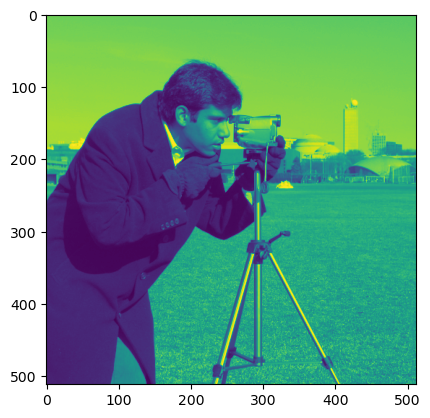

In [12]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft
#from utils import psf_fft, A, AT, gaussian_kernel
from utils_SR import psf_fft, A, AT, gaussian_kernel, totvar, grad_totvar

X = data.camera().astype(np.float64)/255
m,n = X.shape
plt.imshow(X)

sf = 4

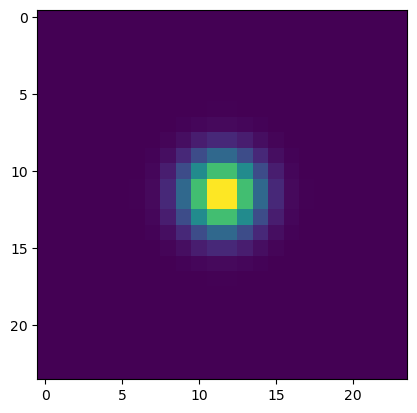

In [13]:
k = gaussian_kernel(24, 3)
plt.imshow(k)
plt.show()

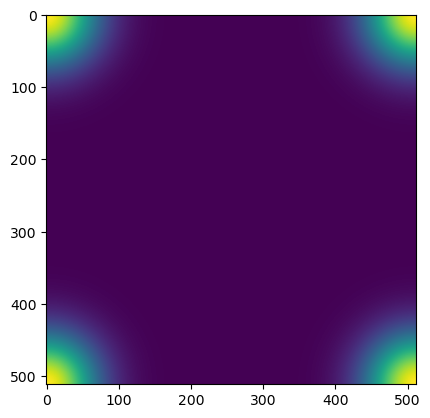

In [14]:
K = psf_fft(k, 24, X.shape)
plt.imshow(np.abs(K))
plt.show()

In [15]:
sigma = 0.02
np.random.seed(42)

X_blurred = A(X, K, sf)
noise = np.random.normal(size=X_blurred.shape)*sigma


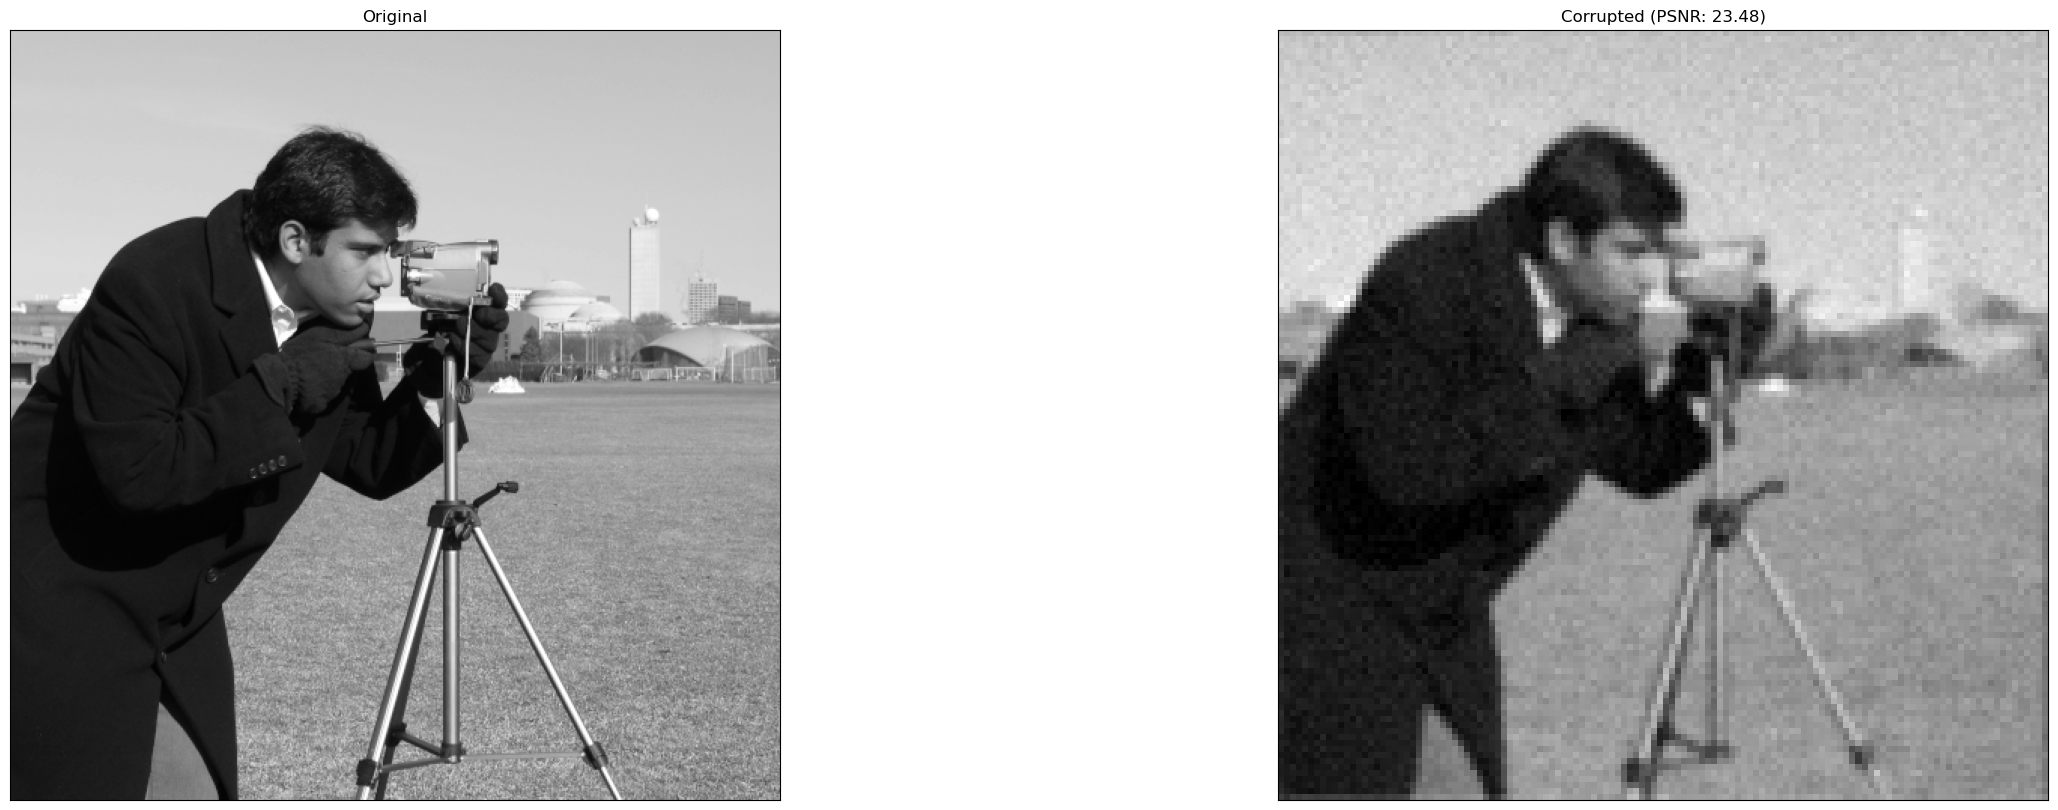

In [19]:
y = X_blurred + noise
ATy = AT(y, K, sf)

PSNR = metrics.peak_signal_noise_ratio(X, ATy)
mse = metrics.mean_squared_error(X, ATy)

plt.figure(figsize=(30, 10))
plt.subplot(121).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title(f'Corrupted (PSNR: {PSNR:.2f})')
plt.xticks([]), plt.yticks([])
plt.show()

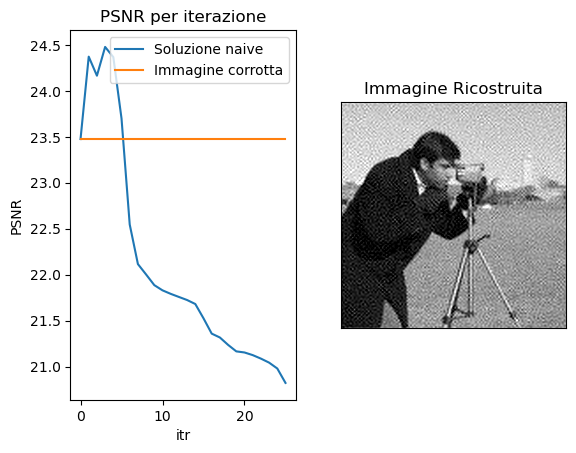

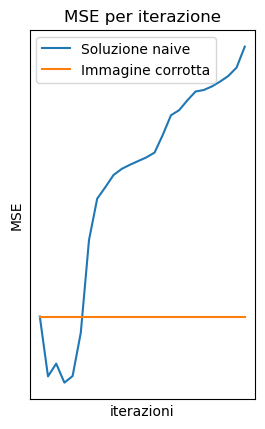

In [24]:
from scipy.optimize import minimize

def f(x):
    x = x.reshape((m, n))
    Ax = A(x, K, sf)
    return 0.5 * np.sum(np.square(Ax - y))

def df(x):
    x = x.reshape((m, n))
    ATAx = AT(A(x,K, sf),K, sf)
    d = ATAx - ATy 
    return d.reshape(m * n)

x0 = ATy.reshape(m*n)
max_iter = 25
res = minimize(f, x0, method='CG', jac=df, options={'maxiter':max_iter, 'return_all':True})

PSNR = np.zeros(max_iter + 1)
for k, x_k in enumerate(res.allvecs):
    PSNR[k] = metrics.peak_signal_noise_ratio(X, x_k.reshape(X.shape))

MSE = np.zeros(max_iter + 1)
for k, x_k in enumerate(res.allvecs):
    MSE[k] = metrics.mean_squared_error(X, x_k.reshape(X.shape))

X_res = res.x.reshape((m, n))


starting_PSNR = np.full(PSNR.shape[0], metrics.peak_signal_noise_ratio(X, ATy))
starting_mse = np.full(max_iter+1, metrics.mean_squared_error(X, ATy))

ax2 = plt.subplot(1, 2, 1)
ax2.plot(PSNR, label="Soluzione naive")
ax2.plot(starting_PSNR, label="Immagine corrotta")
plt.legend()
plt.title('PSNR per iterazione')
plt.ylabel("PSNR")
plt.xlabel('itr')
plt.subplot(1, 2,2).imshow(X_res, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine Ricostruita')
plt.xticks([]), plt.yticks([])
plt.show()

ax3 = plt.subplot(1, 2, 2)
ax3.plot(MSE, label="Soluzione naive")
ax3.plot(starting_mse, label="Immagine corrotta")
plt.legend()
plt.title('MSE per iterazione')
plt.ylabel("MSE")
plt.xlabel('iterazioni')
plt.xticks([]), plt.yticks([])
plt.show()

PSNR: 22.95 (λ = 0.05)
PSNR: 21.85 (λ = 0.10)
PSNR: 18.75 (λ = 0.20)
PSNR: 15.02 (λ = 0.40)


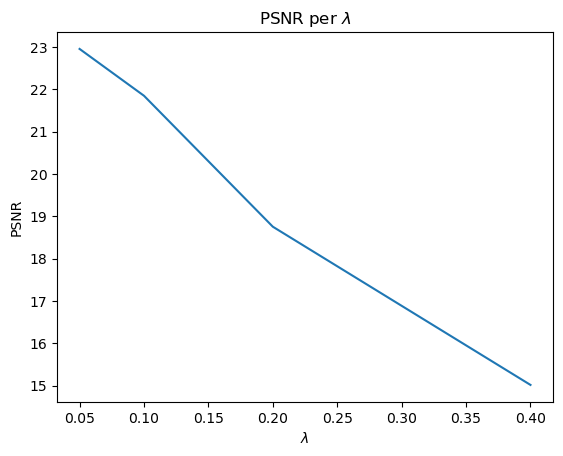

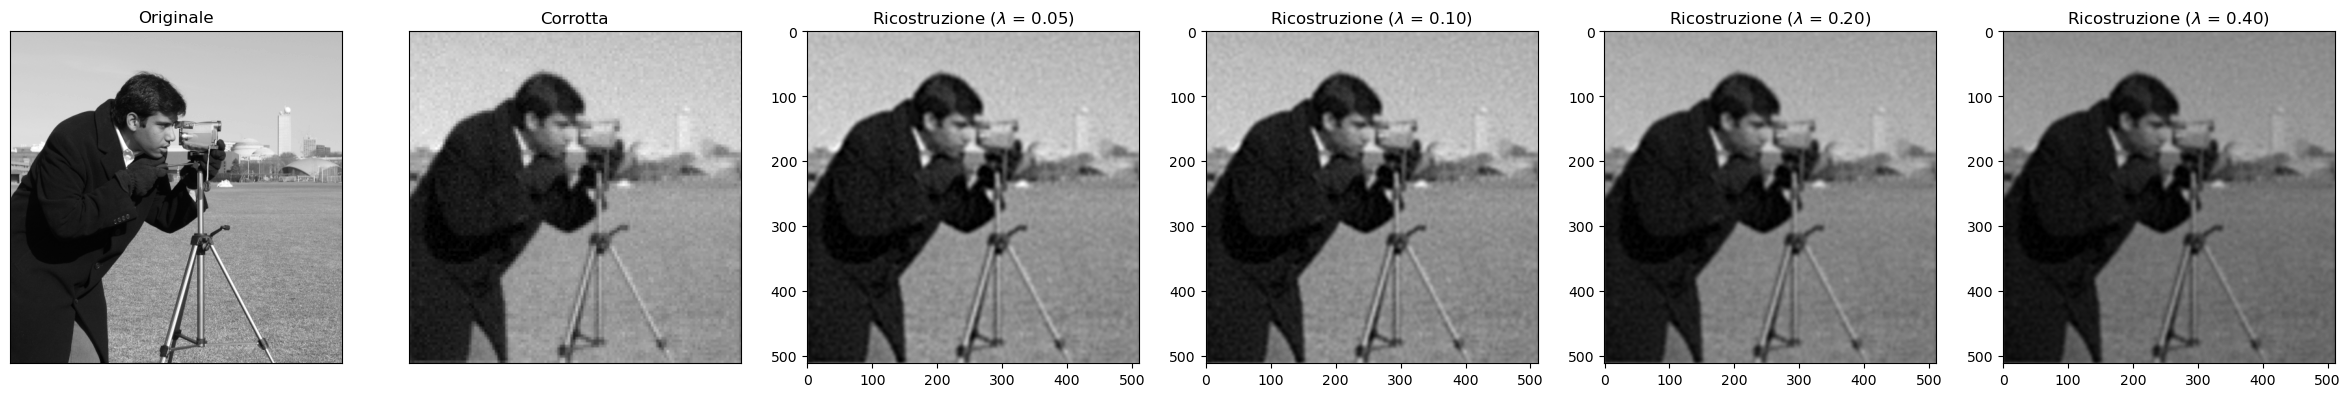

In [25]:
def f(x, L):
    nsq = np.sum(np.square(x))
    x  = x.reshape((m, n))
    Ax = A(x, K, sf)
    return 0.5 * np.sum(np.square(Ax - y)) + 0.5 * L * nsq


def df(x, L):
    Lx = L * x
    x = x.reshape(m, n)
    ATAx = AT(A(x,K, sf),K, sf)
    d = ATAx - ATy
    return d.reshape(m * n) + Lx

x0 = ATy.reshape(m*n)
lambdas = [0.05,0.10,0.20, 0.40]
PSNRs = []
images = []

# Ricostruzione per diversi valori del parametro di regolarizzazione
for i, L in enumerate(lambdas):
    # Esegui la minimizzazione con al massimo 50 iterazioni
    max_iter = 50
    res = minimize(f, x0, (L), method='CG', jac=df, options={'maxiter':max_iter})

    # Aggiungi la ricostruzione nella lista images
    X_curr = res.x.reshape(X.shape)
    images.append(X_curr)

    # Stampa il PSNR per il valore di lambda attuale
    PSNR = metrics.peak_signal_noise_ratio(X, X_curr)
    PSNRs.append(PSNR)
    print(f'PSNR: {PSNR:.2f} (\u03BB = {L:.2f})')
    
    

# Visualizziamo i risultati
plt.plot(lambdas,PSNRs)
plt.title('PSNR per $\lambda$')
plt.ylabel("PSNR")
plt.xlabel('$\lambda$')
plt.show()

plt.figure(figsize=(30, 10))

plt.subplot(1, len(lambdas) + 2, 1).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title("Originale")
plt.xticks([]), plt.yticks([])
plt.subplot(1, len(lambdas) + 2, 2).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title("Corrotta")
plt.xticks([]), plt.yticks([])


for i, L in enumerate(lambdas):
  plt.subplot(1, len(lambdas) + 2, i + 3).imshow(images[i], cmap='gray', vmin=0, vmax=1)
  plt.title(f"Ricostruzione ($\lambda$ = {L:.2f})")
plt.show()